# Question Generator

<img src="img/QGenModel.png">

In [13]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy
from PIL import Image
from VGG_Feature_Extract import VGG_Feature_Extract
use_cuda = torch.cuda.is_available()

## Load Word Embeddings

In [14]:
from torchtext.vocab import load_word_vectors

wv_dict, wv_arr, wv_size = load_word_vectors('.', 'glove.6B', 100)

print('Loaded', len(wv_arr), 'words')

loading word vectors from ./glove.6B.100d.pt
Loaded 400000 words


In [15]:
wv_dict['-SOS-'] = len(wv_dict)
temp = torch.cat([wv_arr, torch.randn((1,100))])
wv_arr = temp
wv_dict['-EOS-'] = len(wv_dict)
temp = torch.cat([wv_arr, torch.randn((1,100))])
wv_arr = temp

In [16]:
def get_wv(w):
    """ returning the word embedding """
    assert type(w) == str, "Not given a string."
    
    if w in wv_dict:
        vw = wv_arr[wv_dict[w]]
        return vw.view(1, 100)
    else:
        print('Word not in Vocab: %s' %(w))    

## Create Dummy Data

In [17]:
data = list()
data.append('-SOS- is it a person ? -EOS-')
data.append('-SOS- is it a dog ? -EOS-')
data.append('-SOS- is it on the left side ? -EOS-')
data.append('-SOS- is it on the ground ? -EOS-')
data.append('-SOS- is it in the sky ? -EOS-')
data.append('-SOS- is it an animal ? -EOS-')
data.append('-SOS- is it an apple ? -EOS-')
data.append('-SOS- is it red ? -EOS-')
data.append('-SOS- is it a cat ? -EOS-')
data.append('-SOS- is it on the right side ? -EOS-')
data.append('-SOS- is it at the top ? -EOS-')
data.append('-SOS- is it at the bottom ? -EOS-')
data.append('-SOS- is it blue ? -EOS-')
data.append('-SOS- are they in the foreground ? -EOS-')
data.append('-SOS- are they in the background ? -EOS-')
data.append('-SOS- are they wearing white ? -EOS-')
data.append('-SOS- are they wearing pants ? -EOS-')
data.append('-SOS- are they eating pizza ? -EOS-')
data.append('-SOS- are they eating a sandwich ? -EOS-')
data.append('-SOS- are they playing guitar ? -EOS-')

print("%i questions loaded." %(len(data)))

image_paths = list()
image_paths.append('val2014/COCO_val2014_000000000042.jpg')
image_paths.append('val2014/COCO_val2014_000000000073.jpg')
image_paths.append('val2014/COCO_val2014_000000000074.jpg')
image_paths.append('val2014/COCO_val2014_000000000133.jpg')
image_paths.append('val2014/COCO_val2014_000000000136.jpg')

print("%i images will be loaded." %(len(image_paths)))

20 questions loaded.
5 images will be loaded.


In [18]:
# get image features
VGG_ex = VGG_Feature_Extract(image_paths)
image_features = list()
for img_p in image_paths:
    image_features.append(VGG_ex.get_features(img_p))

## Prepare Data

In [19]:
vocab = set(' '.join(data).split())
word2index = dict()
index2word = dict()
for i, w in enumerate(vocab):
    word2index[w] = i
    index2word[i] = w
print(word2index)

{'pants': 0, 'side': 1, 'a': 2, 'playing': 3, '-SOS-': 4, 'ground': 5, 'background': 6, 'pizza': 7, 'white': 8, 'sandwich': 9, 'they': 10, 'dog': 11, 'in': 12, 'red': 13, 'cat': 14, 'it': 15, 'on': 16, '-EOS-': 17, 'sky': 18, 'at': 19, 'are': 20, '?': 21, 'right': 22, 'animal': 23, 'apple': 24, 'is': 25, 'top': 26, 'left': 27, 'guitar': 28, 'wearing': 29, 'blue': 30, 'foreground': 31, 'eating': 32, 'the': 33, 'bottom': 34, 'an': 35, 'person': 36}


## Model

### Hyperparameters

In [38]:
embedding_dim = 100
hidden_dim = 100
vocab_size = len(vocab)
target_size = len(vocab)
iterations = 10
feature_dim = 4096

In [39]:
class QGen(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        super(QGen, self).__init__()
        self.hidden_dim = hidden_dim

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim+feature_dim, hidden_dim)

        # The linear layer that maps from hidden state space to word space
        self.hidden2word = nn.Linear(hidden_dim, target_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        if use_cuda:
            return (autograd.Variable(torch.zeros(1, 1, self.hidden_dim)).cuda(),
                    autograd.Variable(torch.zeros(1, 1, self.hidden_dim)).cuda())
        else:
            return (autograd.Variable(torch.zeros(1, 1, self.hidden_dim)),
                    autograd.Variable(torch.zeros(1, 1, self.hidden_dim)))

    def forward(self, sentence, hidden=None):
        
        if hidden == None:
            hidden = self.hidden
            
        # Word embedding of sentence
        if use_cuda:
            embeds = autograd.Variable(torch.FloatTensor(len(sentence.split()), embedding_dim)).cuda()
        else:
            embeds = autograd.Variable(torch.FloatTensor(len(sentence.split()), embedding_dim))

        for i, w in enumerate(sentence.split()):
            embeds[i] = get_wv(w)

        # LSTM
        if use_cuda:
            visual_features = autograd.Variable(torch.randn(len(sentence.split()), 1, feature_dim)).cuda()
        else:
            visual_features = autograd.Variable(torch.randn(len(sentence.split()), 1, feature_dim))
            

        word_embeddings = embeds.view(len(sentence.split()), 1, -1)

        lstm_in = torch.cat([word_embeddings, visual_features], dim=2)

        
        lstm_out, self.hidden = self.lstm(lstm_in, hidden)
        
        
        # mapping hidden state to word output
        word_space = self.hidden2word(lstm_out.view(len(sentence.split()), -1))

        
        # p(w)
        word_scores = F.log_softmax(word_space)
        
        return word_scores, self.hidden

In [42]:
# Init Model, loss function and optimizer
model = QGen(embedding_dim=embedding_dim, hidden_dim=hidden_dim, vocab_size=vocab_size, target_size=target_size)

if use_cuda:
    model.cuda()

loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# See what the scores are before training
inputs = ' '.join(data[0].split()[:-1])
word_scores, _ = model(inputs)

avg_loss = []

for epoch in range(iterations):
    _loss = []
    
    for sentence in data:
        
        # clear gradients
        model.zero_grad()

        # clear hidden state for new datapoint
        model.hidden = model.init_hidden()

        # get the input to the LSTM
        sentence_in = ' '.join(sentence.split()[:-1])

        # get the desired output
        if use_cuda:
            targets = autograd.Variable(torch.LongTensor(len(sentence.split())-1)).cuda()
        else:
            targets = autograd.Variable(torch.LongTensor(len(sentence.split())-1))
            
        for i, w in enumerate(sentence.split()[1:]):
            targets[i] = word2index[w]
            
            
        # run our forward pass.
        word_scores, _ = model(sentence_in)

        # compute loss and do SGD
        loss = loss_function(word_scores, targets)
        if use_cuda:
            loss = loss.cpu()
        _loss.append(loss.data.numpy())
        loss.backward()
        optimizer.step()
        
    avg_loss.append(numpy.mean(_loss))
    
    
    print('Epoch %i Loss %f' %(epoch, avg_loss[-1]))
    
print('Training completed.')


Epoch 0 Loss 3.461645
Epoch 1 Loss 2.923511
Epoch 2 Loss 2.713959
Epoch 3 Loss 2.428927
Epoch 4 Loss 2.371412
Epoch 5 Loss 2.250130
Epoch 6 Loss 2.270658
Epoch 7 Loss 2.062148
Epoch 8 Loss 1.990679
Epoch 9 Loss 2.030633
Training completed.


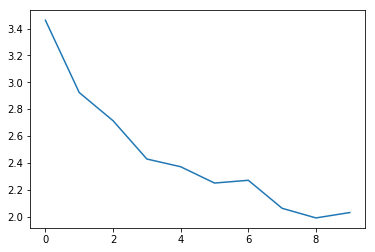

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(avg_loss)
plt.show()

## Testing
Beam Search

In [37]:
# given the start of sentence token
# we use beam search to approximate the most likely question

inputs = '-SOS-'
h_init = model.init_hidden() # clear the first hidden state
max_lenght = 10 # max. question length
top_k = 3 # take the top k succesor word of the SOS token
p = [0]*3 # probability to track the sequence probability
seq = [inputs, inputs, inputs]


# get the first p(w) distribution
# do first forward pass 
if use_cuda:
    input_wv = autograd.Variable(get_wv(inputs)).cuda()
else:
    input_wv = autograd.Variable(get_wv(inputs))
    
out, h_first = model.lstm(input_wv.view(1,1,-1), h_init)
word_space = model.hidden2word(out.view(1, -1))
word_score = F.log_softmax(word_space)

if use_cuda:
    word_score = word_score.cpu()
    
idxs = word_score.data.numpy().ravel().argsort()[-top_k:][::-1]

# get the top_k words and add them to the sequence
p = word_score.data.numpy().ravel()[idxs]
for i, idx in enumerate(idxs):
    seq[i]+= ' ' + index2word[idx]


for i, idx in enumerate(idxs):
    # get the first word and its embedding, set the hidden state
    inputs = index2word[idx]
    if use_cuda:
        input_wv = autograd.Variable(get_wv(inputs)).cuda()
    else:
        input_wv = autograd.Variable(get_wv(inputs))
        
    h = h_first
    
    # keep forward passing and keep track of sequence and respective probability
    for _ in range(1, max_lenght):
        out, h = model.lstm(input_wv.view(1,1,-1), h)
        word_space = model.hidden2word(out.view(1, -1))
        word_score = F.log_softmax(word_space)
        if use_cuda:
            word_score = word_score.cpu()
        p[i] += numpy.max(word_score.data.numpy().ravel())
        inputs = index2word[numpy.argmax(word_score.data.numpy().ravel())]
        seq[i] += ' ' + inputs
        if use_cuda:
            input_wv = autograd.Variable(get_wv(inputs)).cuda()
        else:
            input_wv = autograd.Variable(get_wv(inputs))
        
        # if -EOS- was emitted, stop
        if inputs == '-EOS-':
            break
        
print(p)
print(seq)

RuntimeError: size mismatch, m1: [1 x 100], m2: [4196 x 400] at /Users/soumith/code/builder/wheel/pytorch-src/torch/lib/TH/generic/THTensorMath.c:1237